# Next day close predictor

In this paper I am writing a neuron that will predict the closing price of a security for the next day.
This price prediction will be transferred to the decision-making block based on risk and financial management.

The basic data study is located in the price_predictor_custom_datasets-lgbm notebook
Here we will take an elementary approach to the solution using lags.

As data we will take a dataset from kaggle: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2022-11-10 18:42:58.923934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 18:42:58.923994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Начнем с предсказания цены акций The Procter & Gamble (тикер на NYSE:PG)

## 1. Data preparation

In [2]:
# Read data
df = pd.read_csv("pg.us.txt", parse_dates=["Date"])

In [3]:
df.shape

(12075, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12075 non-null  datetime64[ns]
 1   Open     12075 non-null  float64       
 2   High     12075 non-null  float64       
 3   Low      12075 non-null  float64       
 4   Close    12075 non-null  float64       
 5   Volume   12075 non-null  int64         
 6   OpenInt  12075 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 660.5 KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


In [6]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
12070,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0
12071,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0
12072,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0
12073,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0
12074,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0


In [7]:
# Check min and max Date
df["Date"].min(), df["Date"].max()

(Timestamp('1970-01-02 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [8]:
df=df[["Date", "Close"]]

In [9]:
# Let's write a function to convert the time string to date
def str_to_datetime(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [10]:
# check
datetime_object = str_to_datetime('2022-03-19')
datetime_object

datetime.datetime(2022, 3, 19, 0, 0)

In [11]:
df

,Date,Close
0,1970-01-02,1.3796
1,1970-01-05,1.3875
2,1970-01-06,1.3796
3,1970-01-07,1.4039
4,1970-01-08,1.4198
...,...,...
12070,2017-11-06,86.0500
12071,2017-11-07,86.9800
12072,2017-11-08,87.5800
12073,2017-11-09,87.7800


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12075 non-null  datetime64[ns]
 1   Close   12075 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 188.8 KB


In [13]:
target_date = str_to_datetime('2016-11-10')

In [14]:
target_date

datetime.datetime(2016, 11, 10, 0, 0)

In [15]:
df=df.set_index("Date")

## 2. Data engineering

In [16]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    '''
     input:
    
        dataframe - DataFrameObject - The frame being studied
    
        first_date_str - str - The initial date in YYYY-MM-DD format till which we will start studying
            
        last_date_str - str - End date up to which we will start studying in the YYYYY-MM-DD format
        
        n - int - The number of lags (features)
    
    This function generates additional features based on time series math.
    It adds offset lags.
    
    output:
    
        ret_df - DataFrameObject - Frame with features and target
    '''
    
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: the size of the "Window" for the lag {n} too big for the data {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

print('Line of documentation: \n', df_to_windowed_df.__doc__)   

Line of documentation: 
 
     input:
    
        dataframe - DataFrameObject - The frame being studied
    
        first_date_str - str - The initial date in YYYY-MM-DD format till which we will start studying
            
        last_date_str - str - End date up to which we will start studying in the YYYYY-MM-DD format
        
        n - int - The number of lags (features)
    
    This function generates additional features based on time series math.
    It adds offset lags.
    
    output:
    
        ret_df - DataFrameObject - Frame with features and target
    


In [17]:
# apply our function
windowed_df = df_to_windowed_df(df, '2016-11-10', '2017-11-10', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2016-11-10,83.936,84.808,83.325,80.444
1,2016-11-11,84.808,83.325,80.444,81.045
2,2016-11-14,83.325,80.444,81.045,80.484
3,2016-11-15,80.444,81.045,80.484,81.084
4,2016-11-16,81.045,80.484,81.084,80.667
...,...,...,...,...,...
248,2017-11-06,86.890,86.510,86.580,86.050
249,2017-11-07,86.510,86.580,86.050,86.980
250,2017-11-08,86.580,86.050,86.980,87.580
251,2017-11-09,86.050,86.980,87.580,87.780


In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
    '''
    input:
    
        windowed_dataframe - DataFrameObject - Frame
    
    This function essentially converts the frame into a ribbon of dates, features and targeting, and so converts 
    types to pass to TensorFlow.
    
    output:
    
        dates - DateTime - Timeline
        X - np_array - features
        Y - np_array - target
    '''
        
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

print('Line of documentation: \n', windowed_df_to_date_X_y.__doc__)  

Line of documentation: 
 
    input:
    
        windowed_dataframe - DataFrameObject - Frame
    
    This function essentially converts the frame into a ribbon of dates, features and targeting, and so converts 
    types to pass to TensorFlow.
    
    output:
    
        dates - DateTime - Timeline
        X - np_array - features
        Y - np_array - target
    


In [19]:
# apply
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# check the size
dates.shape, X.shape, y.shape

((253,), (253, 3, 1), (253,))

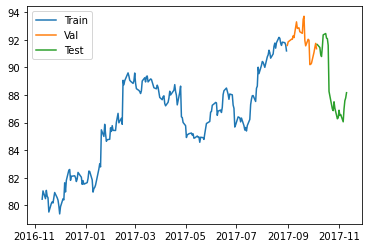

In [20]:
# separate data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Val', 'Test'])

## 3. Train model

In [21]:
# Init model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

2022-11-10 18:43:04.330274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 18:43:04.330340: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 18:43:04.330399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erick-X555DG): /proc/driver/nvidia/version does not exist
2022-11-10 18:43:04.330919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Check structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120)

Epoch 1/120
7/7 [==============================] - 8s 289ms/step - loss: 7366.5518 - mean_absolute_error: 85.7662 - val_loss: 8305.3242 - val_mean_absolute_error: 91.1290
Epoch 2/120
7/7 [==============================] - 0s 25ms/step - loss: 7259.9058 - mean_absolute_error: 85.1427 - val_loss: 8196.3438 - val_mean_absolute_error: 90.5290
Epoch 3/120
7/7 [==============================] - 0s 25ms/step - loss: 7149.9536 - mean_absolute_error: 84.4940 - val_loss: 8062.1426 - val_mean_absolute_error: 89.7848
Epoch 4/120
7/7 [==============================] - 0s 19ms/step - loss: 7009.8423 - mean_absolute_error: 83.6594 - val_loss: 7884.4985 - val_mean_absolute_error: 88.7900
Epoch 5/120
7/7 [==============================] - 0s 25ms/step - loss: 6822.5610 - mean_absolute_error: 82.5315 - val_loss: 7646.8691 - val_mean_absolute_error: 87.4416
Epoch 6/120
7/7 [==============================] - 0s 18ms/step - loss: 6571.6411 - mean_absolute_error: 80.9997 - val_loss: 7328.1377 - val_mean_abs

7/7 [==============================] - 0s 18ms/step - loss: 10.1952 - mean_absolute_error: 2.6093 - val_loss: 31.7507 - val_mean_absolute_error: 5.5622
Epoch 51/120
7/7 [==============================] - 0s 19ms/step - loss: 10.1783 - mean_absolute_error: 2.6104 - val_loss: 32.3379 - val_mean_absolute_error: 5.6149
Epoch 52/120
7/7 [==============================] - 0s 16ms/step - loss: 10.1642 - mean_absolute_error: 2.6240 - val_loss: 33.8706 - val_mean_absolute_error: 5.7499
Epoch 53/120
7/7 [==============================] - 0s 18ms/step - loss: 10.1426 - mean_absolute_error: 2.6185 - val_loss: 32.0496 - val_mean_absolute_error: 5.5893
Epoch 54/120
7/7 [==============================] - 0s 18ms/step - loss: 10.1105 - mean_absolute_error: 2.6051 - val_loss: 32.4129 - val_mean_absolute_error: 5.6218
Epoch 55/120
7/7 [==============================] - 0s 18ms/step - loss: 10.0614 - mean_absolute_error: 2.6065 - val_loss: 33.9133 - val_mean_absolute_error: 5.7539
Epoch 56/120
7/7 [=====

7/7 [==============================] - 0s 17ms/step - loss: 1.2009 - mean_absolute_error: 0.8678 - val_loss: 5.7458 - val_mean_absolute_error: 2.3112
Epoch 101/120
7/7 [==============================] - 0s 17ms/step - loss: 1.1428 - mean_absolute_error: 0.8311 - val_loss: 3.3629 - val_mean_absolute_error: 1.7254
Epoch 102/120
7/7 [==============================] - 0s 18ms/step - loss: 1.1016 - mean_absolute_error: 0.8253 - val_loss: 3.5068 - val_mean_absolute_error: 1.7648
Epoch 103/120
7/7 [==============================] - 0s 17ms/step - loss: 1.2268 - mean_absolute_error: 0.8890 - val_loss: 6.0867 - val_mean_absolute_error: 2.3860
Epoch 104/120
7/7 [==============================] - 0s 17ms/step - loss: 1.4517 - mean_absolute_error: 0.9670 - val_loss: 6.7622 - val_mean_absolute_error: 2.5243
Epoch 105/120
7/7 [==============================] - 0s 18ms/step - loss: 1.3330 - mean_absolute_error: 0.9167 - val_loss: 4.8753 - val_mean_absolute_error: 2.1174
Epoch 106/120
7/7 [===========

7/7 [==============================] - 1s 5ms/step


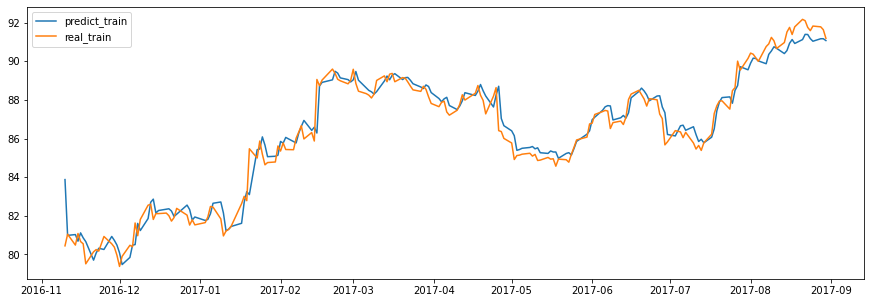

In [24]:
# Compare training data
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['predict_train', 'real_train'])

1/1 [==============================] - 0s 35ms/step


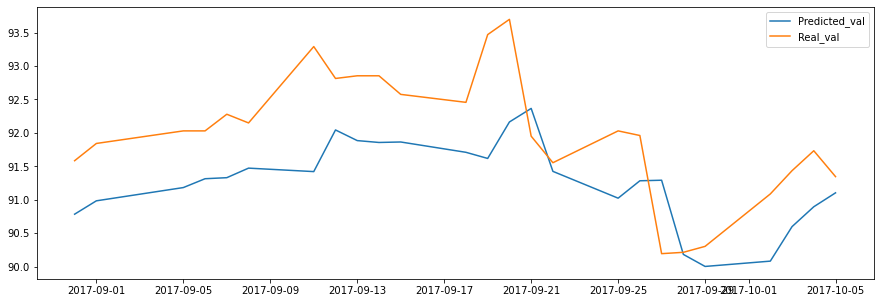

In [25]:
# Compare validation data
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Predicted_val', 'Real_val'])

1/1 [==============================] - 0s 34ms/step


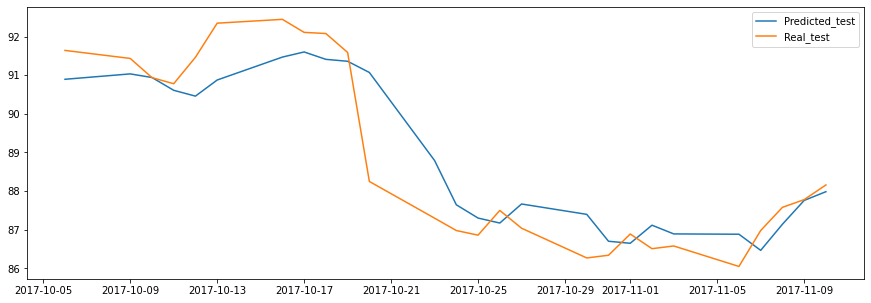

In [26]:
# Compare test data
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Predicted_test', 'Real_test'])

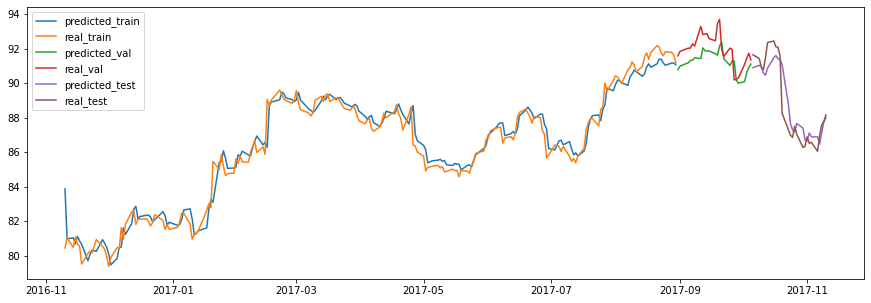

In [27]:
# Check general data
plt.figure(figsize=(15,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['predicted_train',
            'real_train',
            'predicted_val', 
            'real_val',
            'predicted_test', 
            'real_test'])

# Conclusion:
Overall, the error is less than one dollar. And the model learns quickly enough.
At the end of each session it is possible to update the model to the actual data and predict the closing price for the next day. 
There is still room for improvement but the model is much better than the model based on LGBM. 
You can start testing.